### Import and run

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from skimage import measure
from csbdeep.utils import normalize
from stardist.models import StarDist2D
import sys
from tensorflow.keras.models import  load_model
import pickle


# UTILITIES
def camera_align(I): #updated 20260122
    H = np.array([[ 1.00847109e+00,  1.96903443e-02, -1.54332807e+01],
       [-1.68872158e-02,  1.01773292e+00, -2.19123604e+01],
       [-3.15305787e-06,  1.27538375e-06,  1.00000000e+00]])
    height, width = I.shape[:2]
    warped_I = cv2.warpPerspective(I, H, (width, height))
    return warped_I
    

def PCA(I): #find principal direction of bars in image I
    y, x = np.nonzero(I)
    data = np.column_stack((x, y))
    centered = data - np.mean(data, axis=0)
    
    U, S, Vt = np.linalg.svd(centered)

    direction = Vt[0]  # principal direction vector

    R2 = S[0]**2 / (S[0]**2 + S[1]**2)

    return direction, R2


def interpolate_pos_angle(df):
    new_rows = []
    total_missing = 0
    has_angle = 'angle' in df.columns

    for pid, particle_data in df.groupby('particle'):
        particle_data = particle_data.set_index('frame').sort_index()
        frames = particle_data.index.to_numpy()
        if len(frames) == 0:
            continue

        start, end = frames[0], frames[-1]
        missing = sorted(set(range(start, end + 1)) - set(frames))
        if not missing:
            continue

        total_missing += len(missing)
        placeholders = pd.DataFrame(index=missing, columns=particle_data.columns)
        placeholders['particle'] = pid
        placeholders.index.name = 'frame'  # <- fix: ensure index has name

        combined = pd.concat([particle_data, placeholders]).sort_index()

        # Interpolate only x, y
        combined[['x', 'y']] = combined[['x', 'y']].interpolate(
            method='linear', limit_direction='both'
        )

        # Copy other columns (forward/backward fill)
        for col in ['rpx']:
            combined[col] = combined[col].ffill().bfill()

        combined = combined.reset_index()  # restores 'frame' column now
        interpolated = combined[combined['frame'].isin(missing)]
        new_rows.append(interpolated)

    if new_rows:
        df = pd.concat([df, *new_rows], ignore_index=True)

    df = df.sort_values(['particle', 'frame']).reset_index(drop=True)
    print(f'interpolated {total_missing} positions')
    return df

def crop_circle_with_mask_float(img):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    radius = min(center[0], center[1])
    Y, X, C = np.ogrid[:h, :w, :3]
    mask = (X - center[0])**2 + (Y - center[1])**2 <= radius**2
    return img * mask  # retain float values


def generate_cropped_batch(f, img):
    batch = np.empty((len(f), 128, 128, 3), dtype=np.float32)
    for i in range(len(f)):
        row = f.iloc[i]
        x = int(np.around(row['x']))
        y = int(np.around(row['y']))
        r = int(row['rpx'])
        
        h, w = img.shape[:2]
        y1, y2 = max(0, y - r), min(h, y + r)
        x1, x2 = max(0, x - r), min(w, x + r)
        img_crop = img[y1:y2, x1:x2] #CROP OUT SQUARE REGION CONTAINING DISK
        img_crop = cv2.resize(img_crop, (128, 128), interpolation=cv2.INTER_AREA) #RESIZE TO 128*128
        img_crop = cv2.blur(img_crop, ksize=(3,3)).astype(np.float32)/255
        img_crop = crop_circle_with_mask_float(img_crop)#MASK OUT PARTS OUTSIDE DISK

        batch[i] = img_crop
    return batch

def compute_continuous_angles(df):
    df = df.sort_values(['particle', 'frame'])
    df['angle'] = np.nan
    
    for pid, particle_data in df.groupby('particle'):
        accumulated_angle = None
        
        for idx, row in particle_data.iterrows():
            if pd.notna(row['dir_x']) and pd.notna(row['dir_y']):
                raw_angle = np.arctan2(row['dir_y'], row['dir_x'])
                
                if accumulated_angle is None:
                    # First frame: start accumulation
                    accumulated_angle = raw_angle
                else:
                    # Compute the wrapped difference from previous raw angle
                    prev_raw = np.arctan2(prev_dir_y, prev_dir_x)
                    
                    # Try both representations of current angle
                    option1 = raw_angle
                    option2 = raw_angle + np.pi if raw_angle < 0 else raw_angle - np.pi
                    
                    # Pick the one closer to previous (shortest angular path)
                    diff1 = np.angle(np.exp(1j * (option1 - prev_raw)))
                    diff2 = np.angle(np.exp(1j * (option2 - prev_raw)))
                    
                    if abs(diff1) < abs(diff2):
                        delta = diff1
                    else:
                        delta = diff2
                    
                    # Accumulate the change (no wrapping)
                    accumulated_angle += delta
                
                df.loc[idx, 'angle'] = accumulated_angle
                prev_dir_x = row['dir_x']
                prev_dir_y = row['dir_y']
    
    return df


c:\Users\jcTSAI\anaconda3\envs\stardist_tf2.10\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\jcTSAI\anaconda3\envs\stardist_tf2.10\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\jcTSAI\anaconda3\envs\stardist_tf2.10\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Experiment name and settings

In [2]:
IMG_DIR = r'N:\PROJ_TPE'
#ENTER EXPERIMENT FOLDER NAME HERE
#WILL BE USED TO NAME OUTPUT PICKLE FILE
EXP_FOLDER = 'TPE_20260122A01_N=265x2_5e-4rps_10fps_steady_2000frames'

def max_num(IMG_DIR,  EXP_FOLDER):
    files = os.listdir(os.path.join(IMG_DIR, EXP_FOLDER))
    frame_numbers = [int(f.split('_')[1].split('.')[0]) for f in files if f.startswith('Ic_') and f.endswith('.png')]
    return np.max(frame_numbers) if frame_numbers else 0

max_index = int(max_num(IMG_DIR, EXP_FOLDER))
print(f"Max image index found: {max_index}")
max_frame = int(max_index/2)
print(f"Max image frame: {max_frame}")

#OUTPUT PICKLE
PKL_DIR = r'M:\Archive\Proj_TPE\Disk_traj_files'
pickle_path = os.path.join(PKL_DIR, EXP_FOLDER)

roi = (250,1200, 0, 2000) #ROI FOR in y and x direction


Max image index found: 4001
Max image frame: 2000


### Load models

In [3]:
MODEL_DIR = r'O:\LJJ202107\LJJ Jupyter Notebook Collection\stardist training and logistics\stardist_models'
model_name = "09-22_12-29"
model = StarDist2D(None, name=model_name, basedir=MODEL_DIR)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.724202, nms_thresh=0.3.


### Load images and predict

In [9]:
axis_norm = (0,1)   # normalize channels independentl
import gc
import tensorflow as tf

records = [] #empty list to store results temporarily
k_list = np.zeros(max_frame+1, dtype=int)

for frame in range(1, max_frame + 1):
#for frame in [100]:
    # Try both possible k values
    k1 = frame * 2 + 1
    k2 = frame * 2
    
    # Load both images
    path1 = os.path.join(IMG_DIR, EXP_FOLDER, f'Ic_{k1:d}.png')
    path2 = os.path.join(IMG_DIR, EXP_FOLDER, f'Ic_{k2:d}.png')
    
    I1 = camera_align(cv2.flip(cv2.imread(path1), 1))
    I2 = camera_align(cv2.flip(cv2.imread(path2), 1))
    
    # Compare intensity sums on green channel
    sum1 = I1[:,:,1].sum()
    sum2 = I2[:,:,1].sum()
    
    # Choose the brighter one
    if sum1 > sum2:
        I = I1
        k = k1
    else:
        I = I2
        k = k2
    
    sys.stdout.write(f"\rProcessing frame: {frame}, k = {k}")
    sys.stdout.flush()
    
    k_list[frame] = k

    Ig = I[roi[0]:roi[1], roi[2]:roi[3], 1] #GREEN CHANNEL 

    X = normalize(Ig,1,99.8,axis=axis_norm)
    #PREDICT 
    mask, detail = model.predict_instances(X, n_tiles=model._guess_n_tiles(X), show_tile_progress=False)

    # Compute properties
    props = measure.regionprops(mask)

    # Create a list of dicts
    for region in props:
        y, x = region.centroid  # note: (row, col) = (y, x)
        records.append({
            "frame": frame,
            "x": x,
            "y": y,
            "area": region.area,
            "ecc": region.eccentricity
        })
    
    # Delete large variables explicitly
    del I, Ig, X, mask, detail, props
    
    # Clear memory periodically
    if frame % 100 == 0:
        gc.collect()
        tf.keras.backend.clear_session()

df = pd.DataFrame.from_records(records)

Processing frame: 2000, k = 4001

### Filter Dataframe

Text(0.5, 0.98, 'Filtered disks')

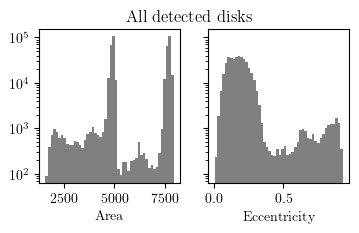

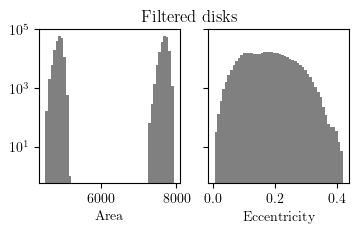

In [10]:
# Find your Times New Roman font file path
times_new_roman_path = r"C:\Windows\Fonts\times.ttf"
from matplotlib import font_manager
times_new_roman_font = font_manager.FontProperties(fname=times_new_roman_path)
plt.rcParams['font.family'] = times_new_roman_font.get_name()
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Before filter
#plot area histogram to inspect
fig, axes = plt.subplots(1, 2, figsize=(4, 2), sharey=True)
axes[0].hist(df['area'], bins=50, color='gray')
axes[0].set_yscale('log')
axes[0].set_xlabel('Area')

#plot eccentricity histogram to inspect
axes[1].hist(df['ecc'], bins=50, color='gray')
axes[1].set_yscale('log')
axes[1].set_xlabel('Eccentricity')
fig.suptitle('All detected disks')

################################## Filter Dataframe ################################################
df_filtered = df[(df["x"] < 1860)&(df["x"] > 100)&(df["y"] > 50)] #trim off boundary 
df_filtered = df_filtered[df_filtered["ecc"] < 0.6] #filter eccentricity #ecc filter changed to 0.6 20250923
df_filtered.loc[:,'rpx'] = 46 #add radius column
df_filtered.loc[df_filtered['area']<6000, 'rpx'] = 37

#####################################################################################################

#After filter
#plot area histogram to inspect
fig2, axes2 = plt.subplots(1, 2, figsize=(4, 2), sharey=True)
axes2[0].hist(df_filtered['area'], bins=50, color='gray')
axes2[0].set_yscale('log')
axes2[0].set_xlabel('Area')

#plot eccentricity histogram to inspect
axes2[1].hist(df_filtered['ecc'], bins=50, color='gray')
axes2[1].set_yscale('log')
axes2[1].set_xlabel('Eccentricity')
fig2.suptitle('Filtered disks')


Plot random frame to inspect

Randomly selected frame: 1318


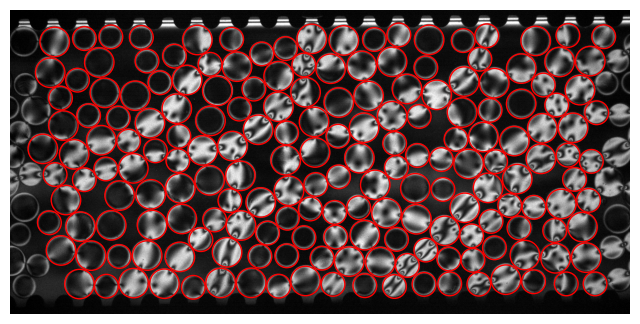

In [13]:
from matplotlib.patches import Circle

frame = np.random.choice(df_filtered['frame'].unique())
print(f"Randomly selected frame: {frame}")

#k = k_list[frame]
f = df_filtered[(df_filtered.frame == frame)]
#print(k, frame)
#path = os.path.join(IMG_DIR, EXP_FOLDER, f'Ic_{k:d}.png')
path = os.path.join(IMG_DIR, EXP_FOLDER, f'Ib_{frame+1}.png')
test_img = cv2.imread(path)[roi[0]:roi[1], roi[2]:roi[3], 0]
#test_img = camera_align(cv2.flip(cv2.imread(path), 1))[roi[0]:roi[1], roi[2]:roi[3], 0]

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(test_img, cmap = 'gray')  # Your raw image

for _, row in f.iterrows():
    circ = Circle((row["x"], row["y"]), row["rpx"], edgecolor='red', facecolor='none', linewidth=1)
    ax.add_patch(circ)
plt.axis('off')
plt.show()


### Link coordinates into trajectory

In [48]:
import trackpy as tp

# link particles
F_linked = tp.link(df_filtered, search_range=30, memory=10)
F_linked = interpolate_pos_angle(F_linked)

# Mark boundary particles
F_linked['boundary'] = (F_linked.x < 200) | (F_linked.x > 1786) | (F_linked.y < 120) | (F_linked.y > 820)

# Change radius to mode value for each particle
F_linked['rpx'] = F_linked.groupby('particle')['rpx'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else x)


Frame 2000: 188 trajectories present.
interpolated 25 positions


### Find rotation angles

incorporated from TPE_rotation_angle_finder

In [49]:
records = [] #empty list to store results temporarily
show = False
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
R2_list = []

# Initialize direction columns if they don't exist
if 'dir_x' not in F_linked.columns:
    F_linked['dir_x'] = np.nan
if 'dir_y' not in F_linked.columns:
    F_linked['dir_y'] = np.nan

I_dict_green = {}
for frame in range(1, max_frame + 1):
    # Use the k value that was NOT chosen in the previous cell
    k1 = frame * 2 + 1
    k2 = frame * 2
    k_chosen = k_list[frame]
    
    # Choose the k that wasn't selected
    if k_chosen == k1:
        k = k2
    else:
        k = k1
    
    sys.stdout.write(f"\rProcessing frame: {frame}, k = {k}")
    sys.stdout.flush()
    path = os.path.join(IMG_DIR, EXP_FOLDER, f'Ic_{k:d}.png')
    I = camera_align(cv2.flip(cv2.imread(path), 1))
    I = I[roi[0]:roi[1], roi[2]:roi[3], 0] #BLUE CHANNEL 
    f = F_linked[F_linked.frame==frame]

    for id, row in f.iterrows(): 

        (yc, xc) = row['y'], row['x']  
        roi_half_length = row['rpx'] * 0.6 #length of the bar 
        y1, y2 = int(yc-roi_half_length), int(yc+roi_half_length) 
        x1, x2 = int(xc-roi_half_length), int(xc+roi_half_length) 
        uv_roi = I[y1:y2, x1:x2] 
        if uv_roi.size > 0 and uv_roi.shape[0] > 0 and uv_roi.shape[1] > 0: 
            # #smooth image 
            uv_roi = cv2.GaussianBlur(uv_roi, (5,5), 1) 
            # use Otsu threshold on grayscale image 
            _, binarize = cv2.threshold(uv_roi, 0, 255, cv2.THRESH_OTSU) 
            binarize = cv2.morphologyEx(binarize, cv2.MORPH_ERODE, kernel, iterations=2) 
            direction, R2 = PCA(binarize) #find principal direction vector
            # update the original dataframe F (not the temporary slice f) 
            F_linked.loc[id, 'dir_x'] = direction[0]
            F_linked.loc[id, 'dir_y'] = direction[1]
            F_linked.loc[id, 'angle_R2'] = R2
            R2_list.append(R2)

F_linked = compute_continuous_angles(F_linked)
F_linked.drop(['dir_x', 'dir_y'], axis=1, inplace=True)

Processing frame: 2000, k = 4000

3222 1611


(-0.5, 1935.5, 949.5, -0.5)

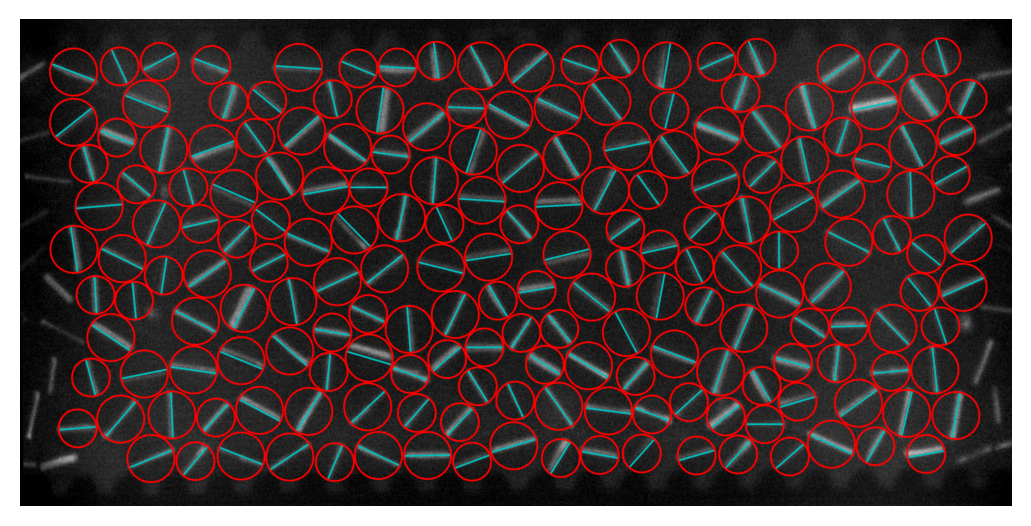

In [53]:
from draw_particle_orientation import *
plt.rcParams['figure.dpi'] = 200

frame = 1611
k1 = frame * 2 + 1
k2 = frame * 2
k_chosen = k_list[frame]

if k_chosen == k1:
    k = k2
else:
    k = k1

print(k, frame)
path = os.path.join(IMG_DIR, EXP_FOLDER, f'Ic_{k1+1:d}.png')
I = camera_align(cv2.flip(cv2.imread(path), 1))
I = I[roi[0]:roi[1], roi[2]:roi[3], 0] #BLUE CHANNEL 
if I.ndim == 2:  
    I = cv2.cvtColor(I, cv2.COLOR_GRAY2BGR)

    
res = draw_particle_orientation(I.copy(),F_linked[(F_linked.frame==frame)], show = False, linecolor='c', linewidth=2)
plt.imshow(res)
plt.axis('off')


### Predict Forces

In [54]:


#image_folder = os.path.join(image_dir, experiment_name)
#traj_filename = os.path.join(traj_dir, experiment_name +'.pkl')

#with open(traj_filename, 'rb') as f:
#    F = pickle.load(f) 

force_model_15 = load_model(r"C:\Users\jcTSAI\Desktop\PE_Force_models\TotalForce_VGG19_20251125_D15_full_range_FineTuned.h5")
force_model_12 = load_model(r"C:\Users\jcTSAI\Desktop\PE_Force_models\TotalForce_VGG19_20251126_D12_full_range_FineTuned.h5")

In [57]:

F_linked['predicted_tot_force'] = np.nan

for frame in range(1, F_linked.frame.max()+1): ############################# START FRAME LOOP
#for frame in [242]:
    print(frame)

    image_path = os.path.join(IMG_DIR,EXP_FOLDER,'Ib_'+str(frame+1)+'.png')
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    img = img[250:1200, :]  # crop top/bottom

    f12 = F_linked[(F_linked.frame==frame)&(F_linked.rpx<40)]
    f15 = F_linked[(F_linked.frame==frame)&(F_linked.rpx>40)]
    batch_crops_12 = generate_cropped_batch(f12, img)
    batch_crops_15 = generate_cropped_batch(f15, img)

    # Run the model in a single batch
    preds12 = force_model_12.predict(batch_crops_12, batch_size=32, verbose=1)*0.8
    preds15 = force_model_15.predict(batch_crops_15, batch_size=32, verbose=1)

    preds12_series = pd.Series(preds12.flatten(), index=f12.index)
    preds15_series = pd.Series(preds15.flatten(), index=f15.index)

    F_linked.loc[f12.index, 'predicted_tot_force'] = preds12_series
    F_linked.loc[f15.index, 'predicted_tot_force'] = preds15_series
 



1
3/3 [==============================] - 0s 102ms/step
2
3/3 [==============================] - 0s 71ms/step
3
3/3 [==============================] - 0s 69ms/step
4
3/3 [==============================] - 0s 70ms/step
5
3/3 [==============================] - 0s 71ms/step
6
3/3 [==============================] - 0s 71ms/step
7
3/3 [==============================] - 0s 70ms/step
8
3/3 [==============================] - 0s 49ms/step
9
3/3 [==============================] - 0s 50ms/step
10
3/3 [==============================] - 0s 71ms/step
11
3/3 [==============================] - 0s 112ms/step
12
3/3 [==============================] - 0s 48ms/step
13
3/3 [==============================] - 0s 83ms/step
14
3/3 [==============================] - 0s 70ms/step
15
3/3 [==============================] - 0s 70ms/step
16
3/3 [==============================] - 0s 48ms/step
17
3/3 [==============================] - 0s 69ms/step
18
3/3 [==============================] - 0s 59ms/step
19
3/3 [=========

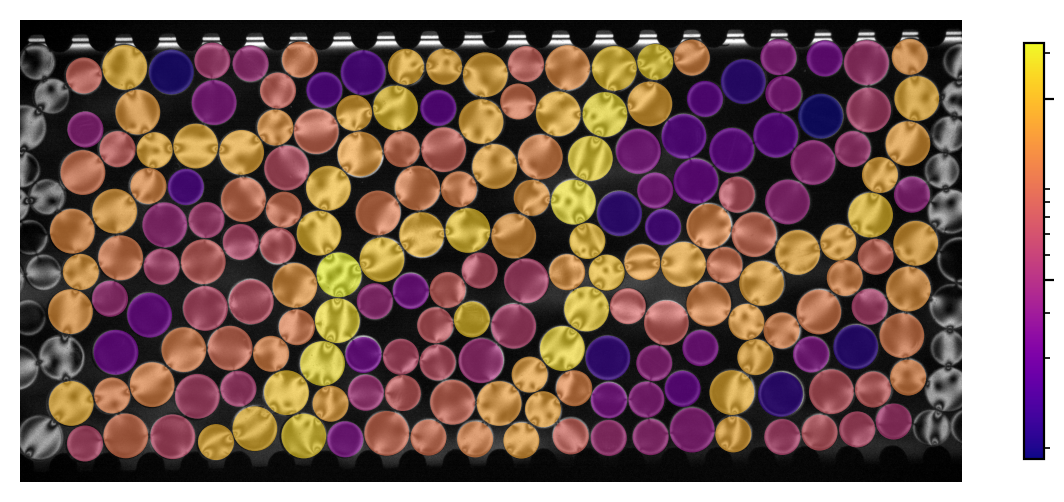

In [59]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.patches import Circle


frame = 142
f = F_linked[(F_linked.frame == frame)]

norm = colors.LogNorm(vmin=abs(f["predicted_tot_force"]).min(), vmax=abs(f["predicted_tot_force"]).max())
cmap = cm.get_cmap('plasma')   # 可用 'plasma', 'inferno', etc.
#frame = np.random.choice(F_linked['frame'].unique())
#print(f"Randomly selected frame: {frame}")


path = os.path.join(IMG_DIR, EXP_FOLDER, f'Ib_{frame+1}.png')
test_img =cv2.imread(path)[roi[0]:roi[1], roi[2]:roi[3], 0]

fig, ax = plt.subplots(figsize=(8, 3))
ax.imshow(test_img, cmap = 'gray')  # Your raw image

for _, row in f.iterrows():
    c = cmap(norm(abs(row["predicted_tot_force"])))
    circ = Circle((row["x"], row["y"]), row["rpx"], edgecolor='none', facecolor=c,alpha = 0.6, linewidth=2)
    ax.add_patch(circ)
plt.axis('off')
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # 必要步驟
cb = plt.colorbar(sm,ax =ax, shrink=0.9, )
cb.set_ticks([0.4, 2])
plt.show()


### save to disk

In [60]:
F_linked.to_pickle(str(pickle_path+'.pkl'))